In [91]:
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
class BacktestCrossMA:
    def __init__(self) -> None:
        self.df = pd.DataFrame()
        self.trades = []
        self.days = []
        self.df_days = pd.DataFrame()
        self.df_trades = pd.DataFrame()

    def load_data(self, path):
        self.df = pd.read_csv(path)
        self.df["date"] = pd.to_datetime(self.df["date"], unit="ms")
        self.df = self.df.set_index(self.df["date"])
        del self.df["date"]

    def populate_indicators(self):
        self.df["ma100"] = self.df["close"].rolling(100).mean()
        self.df["ma200"] = self.df["close"].rolling(200).mean()

    def populate_signals(self):
        self.df["buy_signal"] = False
        self.df["sell_signal"] = False
        self.df.loc[(self.df["ma100"] > self.df["ma200"]), "buy_signal"] = True
        self.df.loc[(self.df["ma100"] < self.df["ma200"]), "sell_signal"] = True

    def run_backtest(self):
        balance = 1000
        position = None
        fees = 0.0007
        self.trades = []
        self.days = []
        previous_day = -1
        asset = 'BTC'

        for index, row in self.df.iterrows():
            current_day = index.day
            if previous_day != current_day:
                temp_balance = balance
                if position:
                    close_price = row["close"]
                    trade_result = (close_price - position["open_price"]) / position[
                        "open_price"
                    ]
                    close_size = (
                        position["open_size"] + position["open_size"] * trade_result
                    )
                    fee = close_size * fees
                    close_size = close_size - fee
                    temp_balance = temp_balance + close_size - position["open_size"]
                self.days.append({
                    "day":index.date(),
                    "balance":temp_balance,
                    "price":row['close']
                })
            previous_day = current_day
            
            if position is None and row["buy_signal"]:
                open_price = row["close"]
                open_size = balance
                fee = open_size * fees
                open_size = open_size - fee
                balance = balance - fee
                stop_loss = open_price - (open_price * 0.3)
                position = {
                    "open_price": open_price,
                    "open_size": balance,
                    "open_date": index,
                    "open_fee": fee,
                    "open_reason": "Market Buy",
                    "open_balance": balance,
                    "stop_loss": stop_loss,
                }
                print(f"{index} - Buy for {balance}$ of {asset} at {open_price}$")

            elif position and row["low"] < position["stop_loss"]:
                close_price = position["stop_loss"]
                trade_result = (close_price - position["open_price"]) / position[
                    "open_price"
                ]
                close_size = (
                    position["open_size"] + position["open_size"] * trade_result
                )
                fee = close_size * fees
                close_size = close_size - fee
                balance = balance + close_size - position["open_size"]
                self.trades.append(
                    {
                        "open_date": position["open_date"],
                        "close_date": index,
                        "open_price": position["open_price"],
                        "close_price": close_price,
                        "open_size": position["open_size"],
                        "close_size": close_size,
                        "open_fee": position["open_fee"],
                        "close_fee": fee,
                        "open_reason": position["open_reason"],
                        "close_reason": "Stop Loss",
                        "open_balance": position["open_balance"],
                        "close_balance": balance,
                    }
                )
                position = None
                print(f"{index} - Sell for {balance}$ of {asset} at {close_price}$")

            elif position and row["sell_signal"]:
                close_price = row["close"]
                trade_result = (close_price - position["open_price"]) / position[
                    "open_price"
                ]
                close_size = (
                    position["open_size"] + position["open_size"] * trade_result
                )
                fee = close_size * fees
                close_size = close_size - fee
                balance = balance + close_size - position["open_size"]
                self.trades.append(
                    {
                        "open_date": position["open_date"],
                        "close_date": index,
                        "open_price": position["open_price"],
                        "close_price": close_price,
                        "open_size": position["open_size"],
                        "close_size": close_size,
                        "open_fee": position["open_fee"],
                        "close_fee": fee,
                        "open_reason": position["open_reason"],
                        "close_reason": "Market Sell",
                        "open_balance": position["open_balance"],
                        "close_balance": balance,
                    }
                )
                position = None
                print(f"{index} - Sell for {balance}$ of {asset} at {close_price}$")

    def backtest_analysis(self):
        df_trades = pd.DataFrame(self.trades)
        df_days = pd.DataFrame(self.days)

        if df_trades.empty:
            raise Exception("No trades found")
        if df_days.empty:
            raise Exception("No days found")

        df_days['evolution'] = df_days['balance'].diff()
        df_days['daily_return'] = df_days['evolution']/df_days['balance'].shift(1)

        df_trades["trade_result"] = df_trades["close_size"] - df_trades["open_size"]
        df_trades["trade_result_pct"] = (
            df_trades["trade_result"] / df_trades["open_size"]
        )
        df_trades["trades_duration"] = df_trades["close_date"] - df_trades["open_date"]

        df_days["balance_ath"] = df_days["balance"].cummax()
        df_days["drawdown"] = df_days["balance_ath"] - df_days["balance"]
        df_days["drawdown_pct"] = df_days["drawdown"] / df_days["balance_ath"]

        total_trades = len(df_trades)
        total_days = len(df_days)

        good_trades = df_trades.loc[df_trades["trade_result"] > 0]
        total_good_trades = len(good_trades)
        avg_profit_good_trades = good_trades["trade_result_pct"].mean()
        mean_good_trades_duration = good_trades["trades_duration"].mean()
        global_win_rate = total_good_trades / total_trades

        bad_trades = df_trades.loc[df_trades["trade_result"] < 0]
        total_bad_trades = len(bad_trades)
        avg_profit_bad_trades = bad_trades["trade_result_pct"].mean()
        mean_bad_trades_duration = bad_trades["trades_duration"].mean()

        max_days_drawdown = df_days["drawdown_pct"].max()
        initial_balance = df_days.iloc[0]["balance"]
        final_balance = df_days.iloc[-1]["balance"]
        balance_evolution = (final_balance - initial_balance) / initial_balance
        mean_trades_duration = df_trades["trades_duration"].mean()
        avg_profit = df_trades["trade_result_pct"].mean()
        mean_trades_duration = df_trades['trades_duration'].mean()
        mean_trades_per_days = total_trades/total_days

        best_trade = df_trades.loc[df_trades["trade_result_pct"].idxmax()]
        worst_trade = df_trades.loc[df_trades["trade_result_pct"].idxmin()]

        sharpe_ratio = (365**(0.5) * df_days['daily_return'].mean())/df_days['daily_return'].std()

        print(f"Period: [{df_days.iloc[0]['day']}] -> [{df_days.iloc[-1]['day']}]")
        print(f"Initial balance: {round(initial_balance,2)} $")

        print("\n--- General Information ---")
        print(f"Final balance: {round(final_balance,2)} $")
        print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        print(f"Performance: {round(balance_evolution*100,2)} %")
        print(f"Worst Drawdown: -{round(max_days_drawdown*100, 2)}%")
        print(f"Total trades on the period: {total_trades}")
        print(f"Average Profit: {round(avg_profit*100, 2)} %")
        print(f"Global Win rate: {round(global_win_rate*100, 2)} %")

        print("\n--- Trades Information ---")
        print(f"Mean Trades per day: {round(mean_trades_per_days, 2)}")
        print(f"Mean Trades Duration: {mean_trades_duration}")
        print(f"Best trades: +{round(best_trade['trade_result_pct']*100, 2)} % the {best_trade['open_date']} -> {best_trade['close_date']}")
        print(f"Worst trades: {round(worst_trade['trade_result_pct']*100, 2)} % the {worst_trade['open_date']} -> {worst_trade['close_date']}")
        print(f"Total Good trades on the period: {total_good_trades}")
        print(f"Total Bad trades on the period: {total_bad_trades}")
        print(f"Average Good Trades result: {round(avg_profit_good_trades*100, 2)} %")
        print(f"Average Bad Trades result: {round(avg_profit_bad_trades*100, 2)} %")
        print(f"Mean Good Trades Duration: {mean_good_trades_duration}")
        print(f"Mean Bad Trades Duration: {mean_bad_trades_duration}")

        print("\n--- Trades reasons ---")
        print(df_trades["open_reason"].value_counts().to_string())
        print(df_trades["close_reason"].value_counts().to_string())

        self.df_days = df_days
        self.df_trades = df_trades

    def plot_equity_vs_asset(self):
        df_days = self.df_days.copy()
        df_days = df_days.set_index('day')
        fig, ax_left = plt.subplots(figsize=(15, 20), nrows=4, ncols=1)

        ax_left[0].title.set_text("Profit and Lose curve")
        ax_left[0].plot(df_days['balance'], color='royalblue', lw=1)
        ax_left[0].fill_between(df_days['balance'].index, df_days['balance'], alpha=0.2, color='royalblue')
        ax_left[0].axhline(y=df_days.iloc[0]['balance'], color='black', alpha=0.3)
        ax_left[0].legend(['Balance evolution'], loc ="upper left")

        ax_left[1].title.set_text("Asset evolution")
        ax_left[1].plot(df_days['price'], color='sandybrown', lw=1)
        ax_left[1].fill_between(df_days['price'].index, df_days['price'], alpha=0.2, color='sandybrown')
        ax_left[1].axhline(y=df_days.iloc[0]['price'], color='black', alpha=0.3)
        ax_left[1].legend(['Asset evolution'], loc ="upper left")

        ax_left[2].title.set_text("Drawdown curve")
        ax_left[2].plot(-df_days['drawdown_pct']*100, color='indianred', lw=1)
        ax_left[2].fill_between(df_days['drawdown_pct'].index, -df_days['drawdown_pct']*100, alpha=0.2, color='indianred')
        ax_left[2].axhline(y=0, color='black', alpha=0.3)
        ax_left[2].legend(['Drawdown in %'], loc ="lower left")

        ax_right = ax_left[3].twinx()

        ax_left[3].title.set_text("P&L VS Asset (not on the same scale)")
        ax_left[3].plot(df_days['balance'], color='royalblue', lw=1)
        ax_right.plot(df_days['price'], color='sandybrown', lw=1)
        ax_left[3].legend(['Wallet evolution (equity)'], loc ="lower right")
        ax_right.legend(['Asset evolution'], loc ="upper left")

        plt.show()

bt = BacktestCrossMA()
bt.load_data('BTC-USDT.csv')
bt.populate_indicators()
bt.populate_signals()
bt.run_backtest()


2017-08-26 01:00:00 - Buy for 999.3$ of BTC at 4284.0$
2017-09-05 06:00:00 - Sell for 935.5376103163865$ of BTC at 4013.46$
2017-09-10 00:00:00 - Buy for 934.882733989165$ of BTC at 4239.0$
2017-09-11 04:00:00 - Sell for 918.8055046672685$ of BTC at 4169.02$
2017-09-20 06:00:00 - Buy for 918.1623408140014$ of BTC at 3950.0$
2017-09-23 20:00:00 - Sell for 877.9501414819291$ of BTC at 3779.65$
2017-09-27 08:00:00 - Buy for 877.3355763828918$ of BTC at 3937.51$
2017-10-07 04:00:00 - Sell for 972.5738490523511$ of BTC at 4368.0$
2017-10-08 16:00:00 - Buy for 971.8930473580144$ of BTC at 4570.0$
2017-10-20 13:00:00 - Sell for 1194.3706283735378$ of BTC at 5620.06$
2017-10-21 14:00:00 - Buy for 1193.5345689336764$ of BTC at 6124.01$
2017-10-26 05:00:00 - Sell for 1110.1178660715714$ of BTC at 5699.99$
2017-10-29 20:00:00 - Buy for 1109.3407835653213$ of BTC at 6153.05$
2017-11-10 06:00:00 - Sell for 1293.5738804927807$ of BTC at 7179.94$
2017-11-16 21:00:00 - Buy for 1292.6683787764357$ of B

In [93]:
bt.backtest_analysis()

Period: [2017-08-17] -> [2023-07-03]
Initial balance: 1000.0 $

--- General Information ---
Final balance: 10458.37 $
Sharpe Ratio: 1.01
Performance: 945.84 %
Worst Drawdown: -61.08%
Total trades on the period: 142
Average Profit: 2.56 %
Global Win rate: 39.44 %

--- Trades Information ---
Mean Trades per day: 0.07
Mean Trades Duration: 7 days 21:27:27.887323943
Best trades: +95.05 % the 2017-11-16 21:00:00 -> 2017-12-21 21:00:00
Worst trades: -16.12 % the 2021-12-01 19:00:00 -> 2021-12-04 15:00:00
Total Good trades on the period: 56
Total Bad trades on the period: 86
Average Good Trades result: 13.19 %
Average Bad Trades result: -4.36 %
Mean Good Trades Duration: 12 days 15:37:30
Mean Bad Trades Duration: 4 days 19:06:58.604651162

--- Trades reasons ---
open_reason
Market Buy    142
close_reason
Market Sell    142


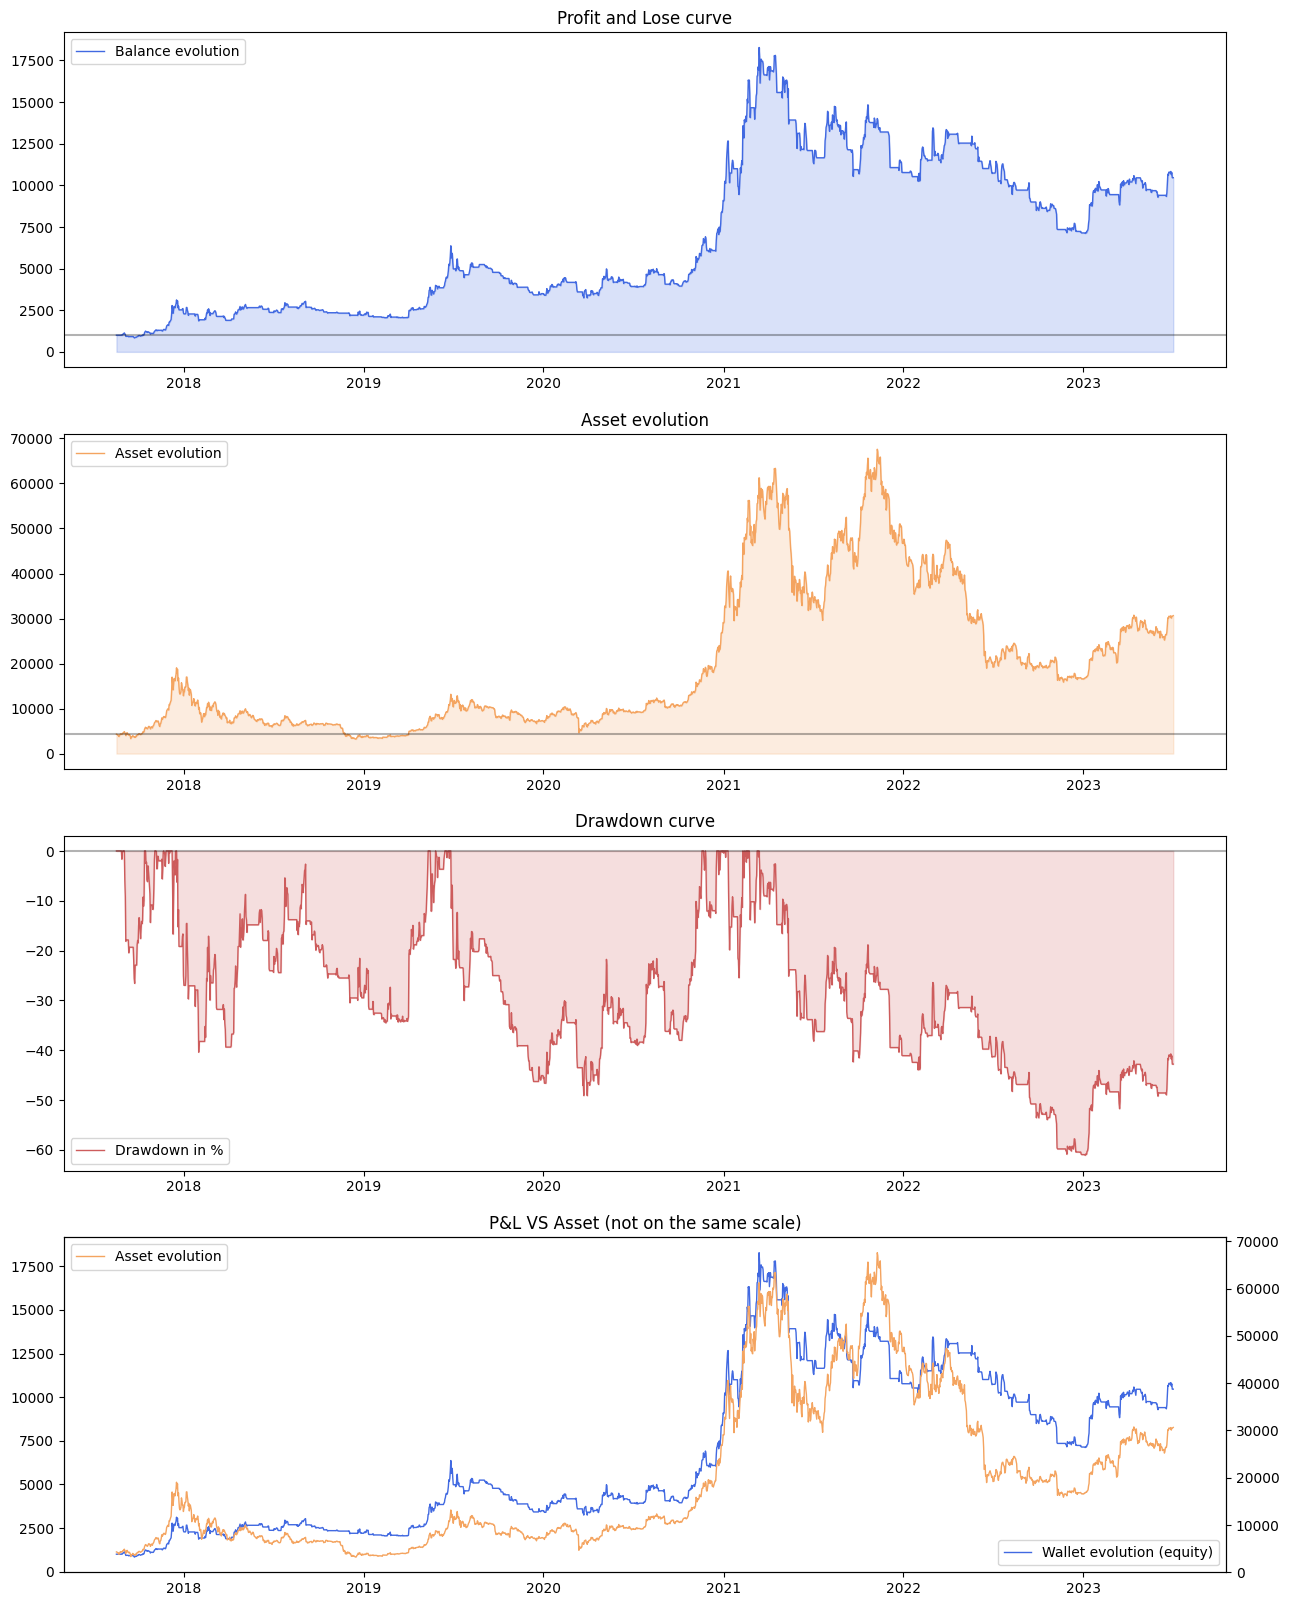

In [94]:
bt.plot_equity_vs_asset()